In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#импорт файлов локально
DATASET_PATH = 'C:\\Users\\Victor\\OneDrive - ITMO UNIVERSITY\\J4132c\\projects\\mrv\\DelayedFlights.csv'

In [ ]:
#импорт файлов для Андрея
DATA_FOLDER = 'drive/My Drive/Учеба/Methods and models for multivariate data analysis/Course project/'
DATASET_PATH = DATA_FOLDER + 'Dataset/DelayedFlights.csv'

In [4]:
#импорт файла для Виктора
DATASET_PATH = '/content/drive/MyDrive/Datasets/DelayedFlights.csv'

In [6]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as st
import statsmodels as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa import stattools

matplotlib.rcParams['figure.figsize'] = (12.0, 7.0)
matplotlib.style.use('ggplot')

**LAB 4**

by: Victor Voronin (J41321c), Andrey Antonov (J41332c), Nelubin Daniil (J41325c)

## *Step 1* 
Choosing the subsample of our dataset to make further analisys on

In [9]:
# loading and displaying our dataset
dataset = pd.read_csv(DATASET_PATH)
dataset.head()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,...,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,...,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [83]:
dataset['Year'].unique()

array([2008])

In [11]:
# subset of our dataset with X_keys being the keys of predictor variables and Y_keys is a target variable
X_keys = ['FlightNum', 'Month', 'DayofMonth', 'DepTime', 'CRSElapsedTime', 'CarrierDelay', 
          'WeatherDelay','NASDelay', 'SecurityDelay', 'LateAircraftDelay']
Y_keys = ['ArrDelay']

In [12]:
df = dataset[(X_keys + Y_keys)]
df = df[(df['DepTime'] < df['DepTime'].quantile(0.99)) &
        (df['DepTime'] > df['DepTime'].quantile(0.011)) &
        (df['CRSElapsedTime'] < df['CRSElapsedTime'].quantile(0.98)) &
        (df['CarrierDelay'] < df['CarrierDelay'].quantile(0.98)) &
        (df['WeatherDelay'] < df['WeatherDelay'].quantile(0.98)) &
        (df['NASDelay'] < df['NASDelay'].quantile(0.98)) &
        (df['SecurityDelay'] < df['SecurityDelay'].quantile(1)) &
        (df['LateAircraftDelay'] < df['LateAircraftDelay'].quantile(0.98)) &
        (df['FlightNum'])
       ]
df.head()

,FlightNum,Month,DayofMonth,DepTime,CRSElapsedTime,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,ArrDelay
5,509,1,3,1937.0,250.0,10.0,0.0,0.0,0.0,47.0,57.0
7,1333,1,3,1644.0,135.0,8.0,0.0,0.0,0.0,72.0,80.0
9,675,1,3,1452.0,240.0,3.0,0.0,0.0,0.0,12.0,15.0
13,623,1,3,1657.0,70.0,7.0,0.0,0.0,0.0,12.0,19.0
35,1035,1,3,1038.0,100.0,7.0,0.0,0.0,0.0,42.0,49.0


In [13]:
#из множества рейсов выберем наиболее часто выполяемые
flight_num = df['FlightNum'].unique()
freq_flightnum = {}
for i in flight_num:
  freq_flightnum[i] = df['FlightNum'][df['FlightNum'] == i].shape[0]

#print them
for a in sorted(freq_flightnum.values(), reverse=True)[:2]:
  print('FlightNum', list(freq_flightnum.keys())[list(freq_flightnum.values()).index(a)])

FlightNum 75
FlightNum 321


In [14]:
#choose predictors for FlightNum 75 from Los-angels (LAX) to Toucson (TAC)
df_75 = df[df["FlightNum"] == 75]
#choose predictors for FlightNum 321 from Los-angels (LAX) to Kansas (MSI)
df_321 = df[df['FlightNum'] == 321]

In [15]:
df_75['Date'] = pd.to_datetime((df_75.DayofMonth.astype(str) + '.' + df_75.Month.astype(str) + '.2008'), dayfirst=True)
df_75.drop(['Month', 'DayofMonth', 'FlightNum'], axis = 1, inplace = True)
df_75.set_index('Date', inplace = True)
df_75.sort_values('Date', inplace=True)
df_75.head()

,DepTime,CRSElapsedTime,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,ArrDelay
Date,,,,,,,,
2008-01-01,1740.0,80.0,4.0,0.0,21.0,0.0,16.0,41.0
2008-01-01,1214.0,152.0,53.0,0.0,6.0,0.0,0.0,59.0
2008-01-01,1959.0,105.0,0.0,0.0,4.0,0.0,60.0,64.0
2008-01-02,1932.0,105.0,28.0,0.0,0.0,0.0,0.0,28.0
2008-01-02,1401.0,75.0,4.0,0.0,16.0,0.0,12.0,32.0


In [16]:
df_321['Date'] = pd.to_datetime((df_321['DayofMonth'].astype(str) + '.' + df_321['Month'].astype(str) + '.2008'), dayfirst=True)
df_321.drop(['Month', 'DayofMonth', 'FlightNum'], axis = 1, inplace = True)
df_321.set_index('Date', inplace=True)
#df_321=df_321.groupby('Date',as_index=True).agg({"ArrDelay": "sum"})
df_321.sort_values('Date', inplace= True)
df_321.head()

,DepTime,CRSElapsedTime,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,ArrDelay
Date,,,,,,,,
2008-01-01,1715.0,223.0,0.0,0.0,43.0,0.0,0.0,43.0
2008-01-01,2043.0,270.0,0.0,7.0,0.0,0.0,12.0,19.0
2008-01-02,1633.0,70.0,0.0,0.0,0.0,0.0,147.0,147.0
2008-01-02,1321.0,75.0,0.0,0.0,0.0,0.0,114.0,114.0
2008-01-02,2042.0,80.0,0.0,0.0,18.0,0.0,112.0,130.0


#Step 1

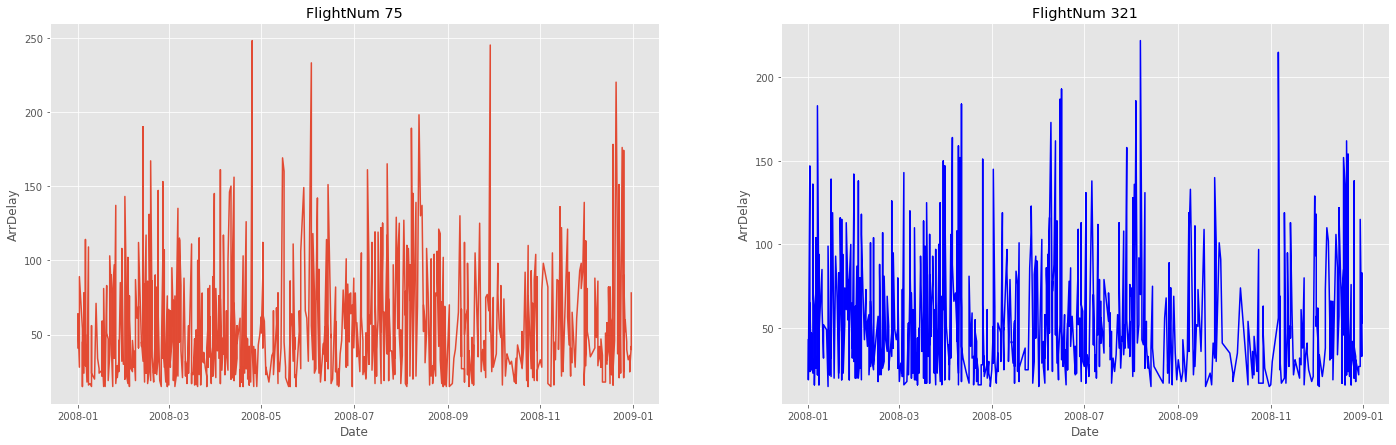

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (24,7))
ax1.plot(df_75['ArrDelay'])
ax1.set_title('FlightNum 75')
ax1.set_xlabel('Date')
ax1.set_ylabel('ArrDelay')
ax2.plot(df_321['ArrDelay'], color = 'Blue')
ax2.set_title('FlightNum 321')
ax2.set_xlabel('Date')
ax2.set_ylabel('ArrDelay')
plt.show();

# Step 2

In [17]:
predictors = ['DepTime', 'CRSElapsedTime', 'CarrierDelay', 
          'WeatherDelay','NASDelay', 'SecurityDelay', 'LateAircraftDelay']
target = ['ArrDelay']

p_threshold = 0.005
lmbds = {f: None for f in target + predictors}

for f in target + predictors:
    result = smt.stattools.adfuller(df_75[f])
    print('Augmented Dickey-Fuller test for %s:\nStatistic value = %5f\np-value = %5f' % (f, result[0], result[1]))
    if result[1] < p_threshold:
        print('%s is stationary\n' % f)
    else:
        print('%s is not stationary\nData will be normalized' % f)
        df_75[f], lmbds[f] = st.boxcox(df_75[f])
        print('Chosen BoxCox lambda:', lmbds[f], '\n')

Augmented Dickey-Fuller test for ArrDelay:
Statistic value = -26.413199
p-value = 0.000000
ArrDelay is stationary

Augmented Dickey-Fuller test for DepTime:
Statistic value = -14.900550
p-value = 0.000000
DepTime is stationary

Augmented Dickey-Fuller test for CRSElapsedTime:
Statistic value = -28.915694
p-value = 0.000000
CRSElapsedTime is stationary

Augmented Dickey-Fuller test for CarrierDelay:
Statistic value = -18.388154
p-value = 0.000000
CarrierDelay is stationary

Augmented Dickey-Fuller test for WeatherDelay:
Statistic value = -29.242249
p-value = 0.000000
WeatherDelay is stationary

Augmented Dickey-Fuller test for NASDelay:
Statistic value = -19.131572
p-value = 0.000000
NASDelay is stationary

Augmented Dickey-Fuller test for SecurityDelay:
Statistic value = -28.819522
p-value = 0.000000
SecurityDelay is stationary

Augmented Dickey-Fuller test for LateAircraftDelay:
Statistic value = -27.852850
p-value = 0.000000
LateAircraftDelay is stationary



as we can see from previous cell, all time series are stationarity (p_value < threshold = 0.005)

# Step 3

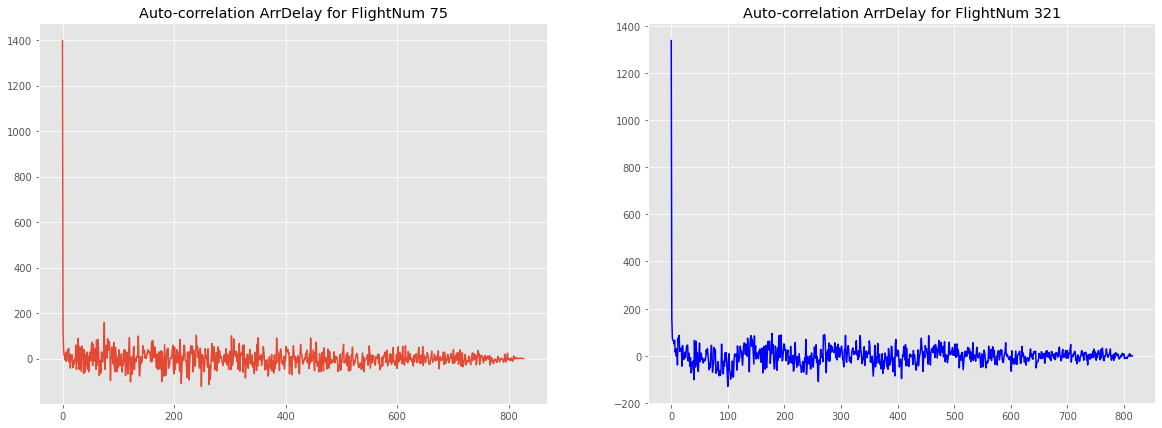

In [180]:
#auto-correlation of target variable for FlightNum 75 and 321
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (20,7))
ax1.plot(smt.acovf(df_75['ArrDelay'], fft=False))
ax1.set_title('Auto-correlation ArrDelay for FlightNum 75')
ax2.plot(smt.acovf(df_321['ArrDelay'], fft=False), color = 'Blue')
ax2.set_title('Auto-correlation ArrDelay for FlightNum 321')
plt.show();

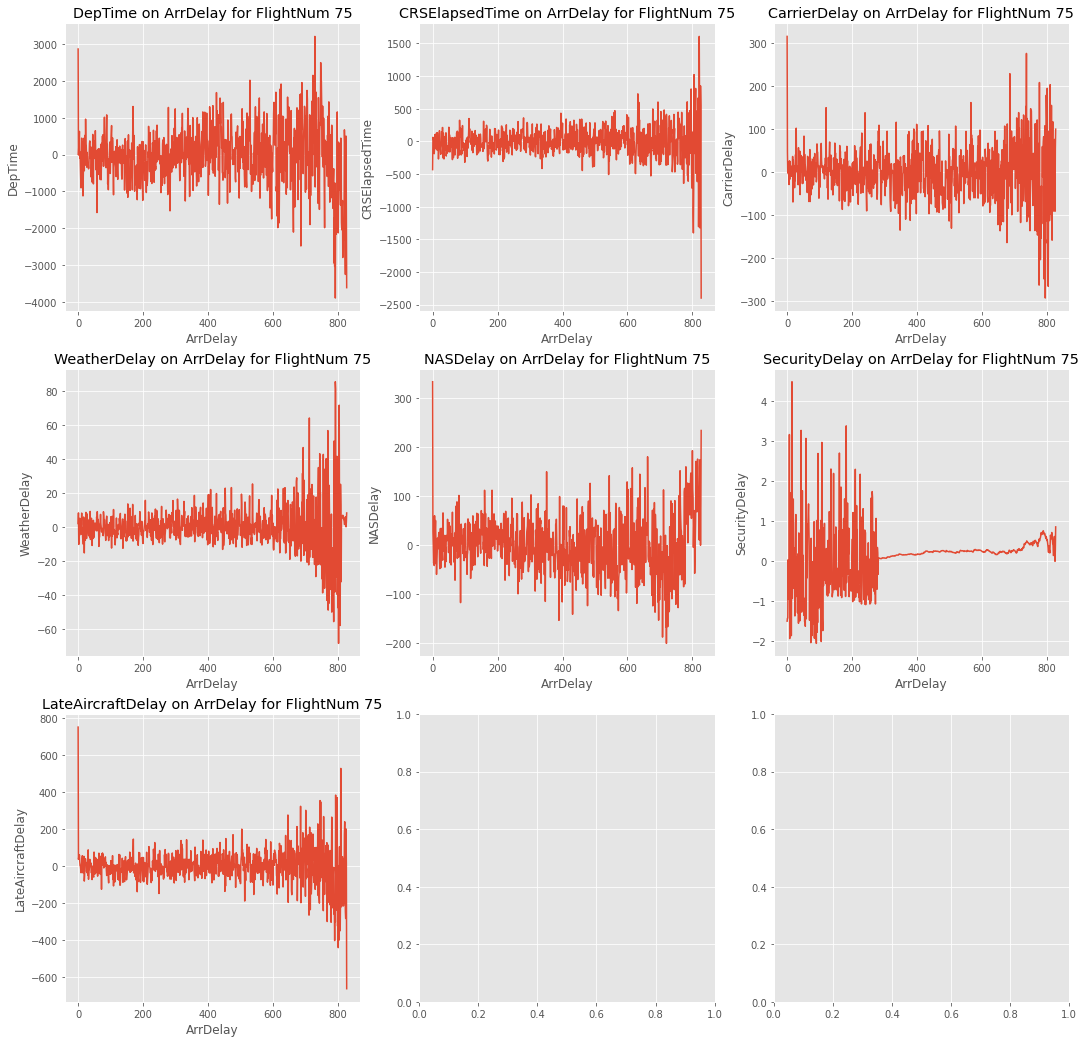

In [193]:
#correlation target variable with predictors for FlightNum 75
fig, ax = plt.subplots(3, 3, figsize = (18,18))
k = 0
for i in range(len(predictors)//2):
    for j in range(len(predictors)//2):
      if k >= len(predictors):
        break
      ax[i,j].plot(smt.ccovf(df_75.iloc[:, k], df_75['ArrDelay']))
      ax[i,j].set_title(predictors[k] + ' on ArrDelay for FlightNum 75')
      ax[i,j].set_xlabel('ArrDelay')
      ax[i,j].set_ylabel(predictors[k])
      k+=1
plt.show()

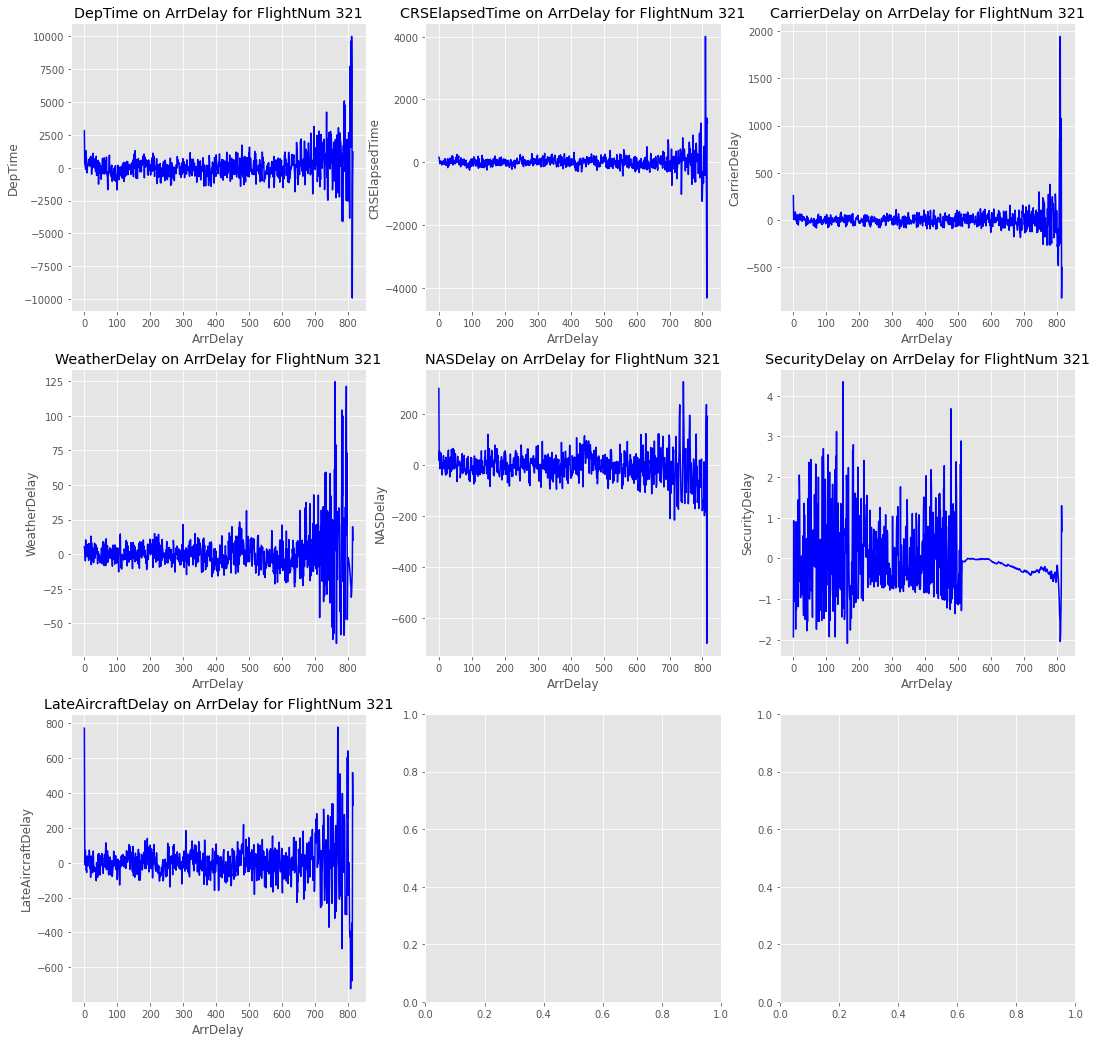

In [194]:
#correlation target variable with predictors for FlightNum 321
fig, ax = plt.subplots(3, 3, figsize = (18,18))
k = 0
for i in range(len(predictors)//2):
    for j in range(len(predictors)//2):
      if k >= len(predictors):
        break
      ax[i,j].plot(smt.ccovf(df_321.iloc[:, k], df_321['ArrDelay']), color = 'Blue')
      ax[i,j].set_title(predictors[k] + ' on ArrDelay for FlightNum 321')
      ax[i,j].set_xlabel('ArrDelay')
      ax[i,j].set_ylabel(predictors[k])
      k+=1
plt.show()

# Step 4

## Filter high frequency with two filters

### Butterworth filter

In [18]:
from scipy import signal
from scipy.ndimage import filters

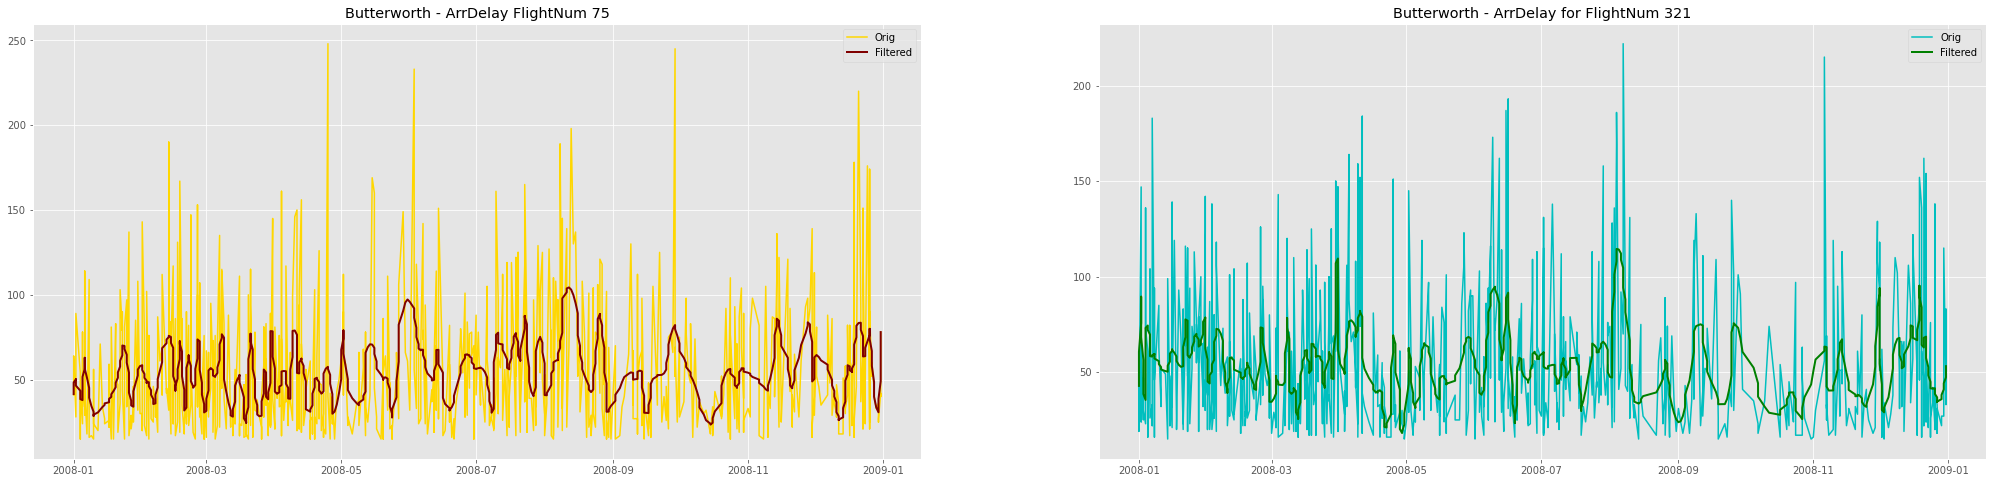

In [66]:
fs = 400 #sampling frequency
fc = 30  #cut frequency
w = fc / (fs / 2) #normalisation

b, a = signal.butter(5, w, 'low')
df_75['ArrDelay_75_btw'] = signal.filtfilt(b, a, df_75['ArrDelay'])
df_321['ArrDelay_321_btw'] = signal.filtfilt(b, a, df_321['ArrDelay'])

plt.figure(figsize=(35, 8))
plt.subplot(1,2,1)
plt.title("Butterworth - ArrDelay FlightNum 75")
plt.plot(df_75['ArrDelay'], label = 'Orig', color = 'gold')
plt.plot(df_75['ArrDelay_75_btw'], linewidth=2, label = 'Filtered', color = 'maroon')
plt.legend()

plt.subplot(1,2,2)
plt.title("Butterworth - ArrDelay for FlightNum 321")
plt.plot(df_321['ArrDelay'], label = 'Orig', color = 'c')
plt.plot(df_321['ArrDelay_321_btw'], linewidth=2, label = 'Filtered', color = 'green')
plt.legend()
plt.show();

### Gaussian filter

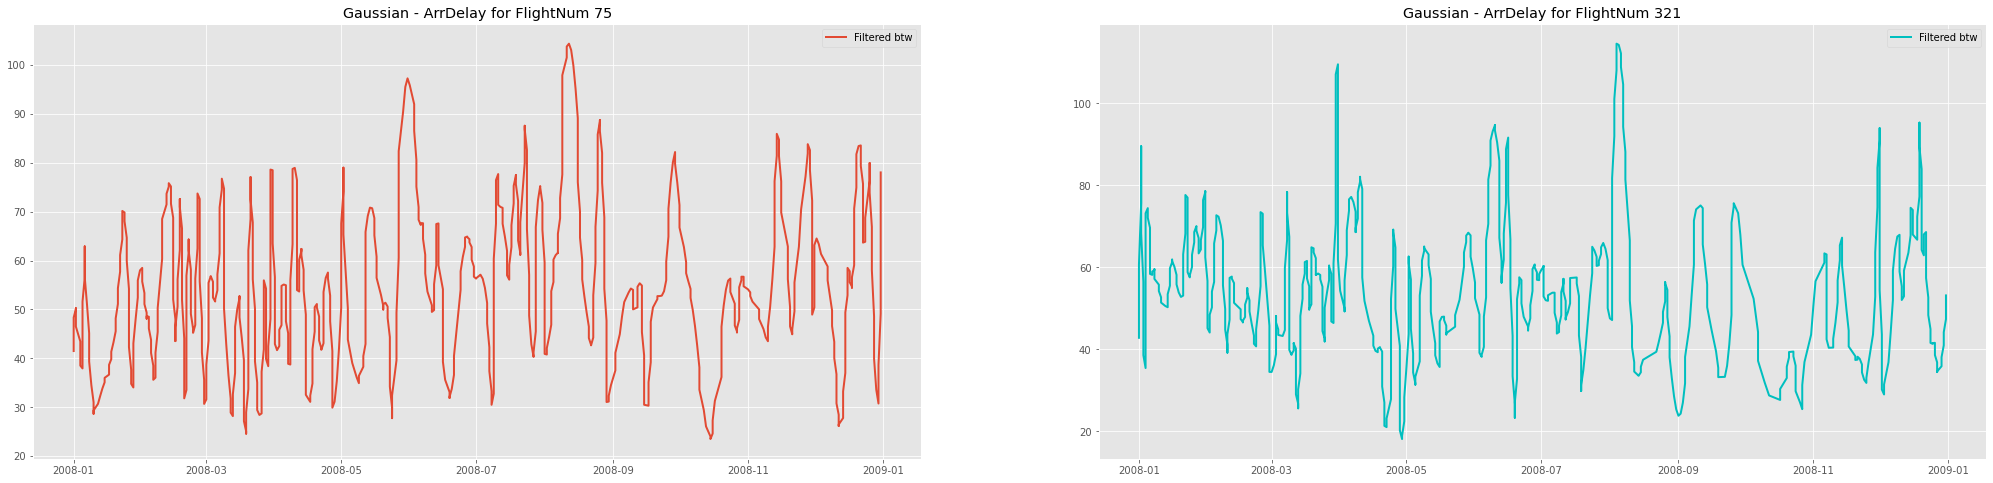

In [68]:
#gauss filter parameters
windows_size = 20
gauss_sd = 5
#windows setup
window = signal.gaussian(windows_size, gauss_sd)

#convolution for the series and window
df_75['ArrDelay_75_gauss'] = signal.convolve(df_75['ArrDelay'], window/window.sum(), mode='same')
df_321['ArrDelay_321_gauss'] = signal.convolve(df_321['ArrDelay'], window/window.sum(), mode='same')

plt.figure(figsize=(35, 8))

plt.subplot(1,2,1)
plt.title("Gaussian - ArrDelay for FlightNum 75")
#plt.plot(df_75['ArrDelay'], label = 'Orig')
#plt.plot(df_75['ArrDelay_75_gauss'], linewidth=2, label = 'Filtered gauss')
plt.plot(df_75['ArrDelay_75_btw'], linewidth=2, label = 'Filtered btw')
plt.legend()

plt.subplot(1,2,2)
plt.title("Gaussian - ArrDelay for FlightNum 321")
#plt.plot(df_321['ArrDelay'], label = 'Orig', color = 'c')
#plt.plot(df_321['ArrDelay_321_gauss'], linewidth=2, label = 'Filtered gauss', color = 'c')
plt.plot(df_321['ArrDelay_321_btw'], linewidth=2, label = 'Filtered btw', color = 'c')
plt.legend()
plt.show();

# Step 5

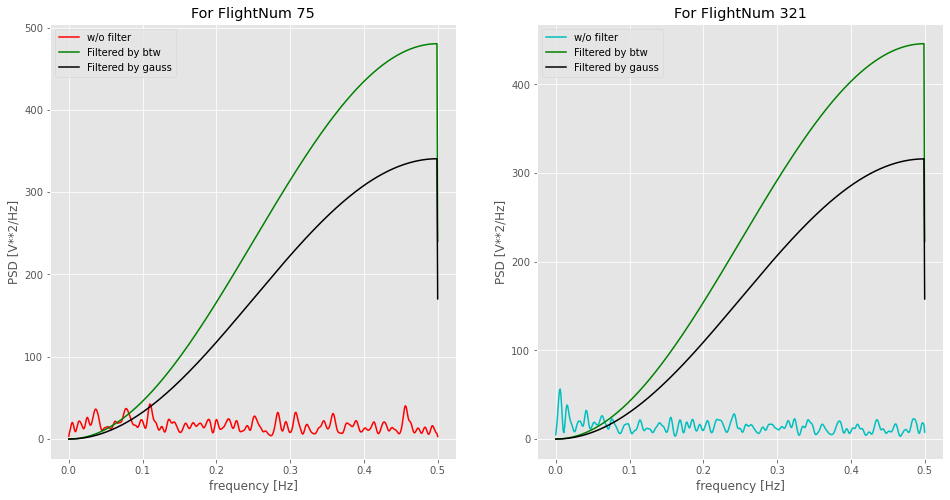

In [21]:
blackman = signal.blackman(M=windows_size)

f, Pxx = signal.welch(df_75['ArrDelay'], fs=1, scaling='spectrum', nfft = 1000)
f_75_btw, Pxx_75_btw = signal.welch(df_75['ArrDelay_75_btw'], fs=1, window=blackman, nfft = 1000, scaling='spectrum')
f_75_gauss, Pxx_75_gauss = signal.welch(df_75['ArrDelay_75_gauss'], fs=1, window=blackman, nfft = 1000, scaling='spectrum')

plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
plt.plot(f, Pxx, color = 'red', label = 'w/o filter')
plt.plot(f_75_btw, Pxx_75_btw, label = 'Filtered by btw', color = 'green')
plt.plot(f_75_gauss, Pxx_75_gauss, label = 'Filtered by gauss', color = 'black')
plt.title('For FlightNum 75')

plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()


f, Pxx = signal.welch(df_321['ArrDelay'], fs=1, scaling='spectrum', nfft = 1000)
f_321_btw, Pxx_321_btw = signal.welch(df_321['ArrDelay_321_btw'], fs=1, window=blackman, nfft = 1000, scaling='spectrum')
f_321_gauss, Pxx_321_gauss = signal.welch(df_321['ArrDelay_321_gauss'], fs=1, window=blackman, nfft = 1000, scaling='spectrum')

plt.subplot(1,2,2)
plt.plot(f, Pxx, color = 'c', label = 'w/o filter')
plt.plot(f_321_btw, Pxx_321_btw, label = 'Filtered by btw', color = 'green')
plt.plot(f_321_gauss, Pxx_321_gauss, label = 'Filtered by gauss', color = 'black')
plt.title('For FlightNum 321')

plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()

plt.show();

# Step 6

In [22]:
from itertools import product
from statsmodels.tsa.arima_model import ARIMA
import datetime
from dateutil.relativedelta import relativedelta
from numpy.linalg import LinAlgError
from sklearn.metrics import r2_score, mean_squared_error

In [23]:
# SARIMA parameters:
ps = range(0,6)
d=1
qs = range(0,6)
Ps = range(0,2)
D=1
Qs= range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print (u"Models to analyse by AIC:", len(parameters_list))

Models to analyse by AIC: 72


In [69]:
targetf_75 = target + ['ArrDelay_75_btw'] + ['ArrDelay_75_gauss']
best_model_75 = {t: None for t in targetf_75}
best_param_75 = {t: None for t in targetf_75}

for t in targetf_75:
    best_aic = float("inf")
    for param in parameters_list:
        #try except for the case of wrong parameters
        try:
            model = smt.statespace.SARIMAX(df_75[t],
                                              order=(param[0], d, param[1]),
                                              seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        except ValueError:
            continue
        except LinAlgError:
            continue
        aic = model.aic

        # save best model, aic, parameters
        if (aic < best_aic):
            best_model_75[t] = model
            best_param_75[t] = param
            best_aic_75 = aic
    print('\n\n============\n' + t + '\n============\n\n')
    print(best_model_75[t].summary())



ArrDelay


                                      SARIMAX Results                                      
Dep. Variable:                            ArrDelay   No. Observations:                  828
Model:             SARIMAX(5, 1, 5)x(1, 1, [], 12)   Log Likelihood               -4254.291
Date:                             Tue, 20 Apr 2021   AIC                           8532.582
Time:                                     23:27:42   BIC                           8589.020
Sample:                                          0   HQIC                          8554.244
                                             - 828                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7603      0.047    -37.848      0.000      -1.851      -1.669
ar.L2         

In [70]:
print("For flightNum 75")
for t in targetf_75:
    print(t)
    print("R2\t", t + ':', r2_score(best_model_75[t].predict(), df_75[t]))
    print("RMSE\t", t + ':', mean_squared_error(best_model_75[t].predict(), df_75[t], squared = False), '\n')
    #print("MAPE\t", t + ':', mean_absolute_percentage_error(best_model[t].predict(), df_321[t], squared = False))

For flightNum 75
ArrDelay
R2	 ArrDelay: -1.8940298001670532
RMSE	 ArrDelay: 44.198991959181896 

ArrDelay_75_btw
R2	 ArrDelay_75_btw: 0.9893399731952863
RMSE	 ArrDelay_75_btw: 1.592028648572359 

ArrDelay_75_gauss
R2	 ArrDelay_75_gauss: 0.986298696818709
RMSE	 ArrDelay_75_gauss: 1.3105556731097172 



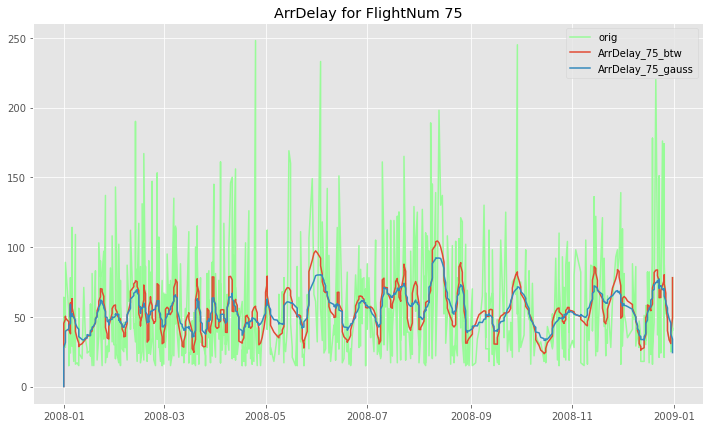

In [81]:
plt.plot(df_75['ArrDelay'], label = 'orig', color = 'palegreen')
for t in targetf_75[1:]:
    plt.plot(best_model_75[t].predict(), label = t)
    plt.legend()
plt.title('ArrDelay for FlightNum 75')
plt.show()

In [72]:
targetf_321 = target + ['ArrDelay_321_btw'] + ['ArrDelay_321_gauss']
best_model_321 = {t: None for t in targetf_321}
best_param_321 = {t: None for t in targetf_321}

for t in targetf_321:
    best_aic = float("inf")
    for param in parameters_list:
        #try except for the case of wrong parameters
        try:
            model = smt.statespace.SARIMAX(df_321[t],
                                              order=(param[0], d, param[1]),
                                              seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        except ValueError:
            continue
        except LinAlgError:
            continue
        aic = model.aic

        # save best model, aic, parameters
        if (aic < best_aic):
            best_model_321[t] = model
            best_param_321[t] = param
            best_aic_321 = aic
    print('\n\n============\n' + t + '\n============\n\n')
    print(best_model_321[t].summary())



ArrDelay


                                      SARIMAX Results                                      
Dep. Variable:                            ArrDelay   No. Observations:                  816
Model:             SARIMAX(5, 1, 5)x(1, 1, [], 12)   Log Likelihood               -4159.709
Date:                             Tue, 20 Apr 2021   AIC                           8343.418
Time:                                     23:39:56   BIC                           8399.678
Sample:                                          0   HQIC                          8365.027
                                             - 816                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8113      0.052    -34.672      0.000      -1.914      -1.709
ar.L2         

In [73]:
print("For flightNum 321")
for t in targetf_321:
    print(t)
    print("R2\t", t + ':', r2_score(best_model_321[t].predict(), df_321[t]))
    print("RMSE\t", t + ':', mean_squared_error(best_model_321[t].predict(), df_321[t], squared = False), '\n')
    #print("MAPE\t", t + ':', mean_absolute_percentage_error(best_model[t].predict(), df_321[t], squared = False))

For flightNum 321
ArrDelay
R2	 ArrDelay: -1.7397741792338794
RMSE	 ArrDelay: 43.09065809778126 

ArrDelay_321_btw
R2	 ArrDelay_321_btw: 0.9839793341282934
RMSE	 ArrDelay_321_btw: 2.098640542771571 

ArrDelay_321_gauss
R2	 ArrDelay_321_gauss: 0.978122473174442
RMSE	 ArrDelay_321_gauss: 1.821950539268922 



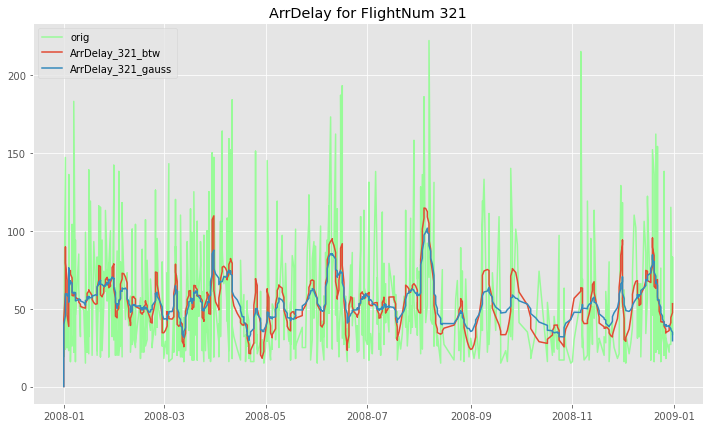

In [83]:
plt.plot(df_321['ArrDelay'], label = 'orig', color = 'palegreen')
for t in targetf_321[1:]:
    plt.plot(best_model_321[t].predict(), label = t)
    plt.legend()
plt.title('ArrDelay for FlightNum 321')
plt.show()

# Step 7

In [ ]:
!pip install https://github.com/nccr-itmo/FEDOT/archive/fix/mo-and-regr-api.zip
!pip install delayed
!pip install statsmodels --upgrade

In [ ]:
from fedot.api.main import Fedot
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [ ]:
# init model for the time series forecasting
model_75 = Fedot(problem='ts_forecasting')
model_321 = Fedot(problem='ts_forecasting')

#run AutoML model design in the same way
chain_75 = model_75.fit(features = df_75.loc[:,['DepTime','CarrierDelay', 'LateAircraftDelay','NASDelay', 'WeatherDelay']], target = df_75.iloc[:,-1])
chain_321 = model_321.fit(features = df_321.loc[:,['DepTime','CarrierDelay', 'LateAircraftDelay','NASDelay', 'WeatherDelay']], target = df_321.iloc[:,-1])

In [ ]:
prediction_75 = model_75.predict(features=df_75.iloc[:,:-1])
prediction_321 = model_321.predict(features=df_321.iloc[:,:-1])

print('Predict for FlightNum 75')
print(model_75.get_metrics(metric_names=['rmse', 'mae', 'mape']))

print("Predict for FlightNum 321")
print(model_321.get_metrics(metric_names=['rmse', 'mae', 'mape']))

In [ ]:
ts_forecast_75 = model_75.forecast(pre_history=df_75.iloc[:,:-1], forecast_length = 30)
ts_forecast_321 = model_321.forecast(pre_history=df_321.iloc[:,:-1], forecast_length = 30)

#plot forecasting result
model_75.plot_prediction()
model_321.plot_prediction()